In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from math import ceil
from pfhedge.nn import Hedger
from pfhedge.nn import BlackScholes
from pfhedge.instruments import BrownianStock

from pfhedge.instruments import EuropeanOption
from pfhedge.nn.modules.mlp import MultiLayerPerceptron
import pfhedge.nn.modules.datahedger as datahedger
from pfhedge.nn.modules.loss import ExpectedShortfall
from importlib import reload
reload(datahedger)


def to_numpy(tensor: torch.Tensor) -> np.array:
    return tensor.cpu().detach().numpy()

def plot_pnl(pnl):
    plt.figure()
    plt.hist(to_numpy(pnl), bins=100)
    
    plt.title("Profit-loss histograms of 50000 price paths for a European option")
    plt.xlabel("Profit-loss")
    plt.ylabel("Number of events")
    plt.grid()
    plt.show()
    
def plot_history(history):
    smooth_history = np.convolve(np.array(history),np.ones(100)/100, 'valid')
    plt.plot(smooth_history)
    plt.xlabel("Number of epochs")
    plt.ylabel("Loss")
    plt.title("Loss histories ")
    plt.show()


### Single trading asset

In [3]:
N_PATHS = 50000

s0 = 1.
dt = 1/365
maturity = 30/365
time_steps = ceil(maturity / dt)

derivative = EuropeanOption(BrownianStock(dt=dt), strike = s0, maturity=maturity)
derivative.simulate(N_PATHS, init_state= s0)

prices = derivative.underlier.spot[...,None]
payoff = derivative.payoff_fn()[:,None]

time_to_maturity = torch.linspace(maturity, 0, time_steps + 1)
time_to_maturity = torch.tile(time_to_maturity, [N_PATHS,1])[...,None]

information = torch.cat([
    torch.log(prices),
    time_to_maturity
    ], axis = -1)

n_asset = prices.shape[-1]
data_set = [prices, information, payoff]
dataset_market = datahedger.MarketDataset(data_set)


In [4]:
model = BlackScholes(derivative)
hedger = Hedger(model, inputs=model.inputs())
hedger.price(derivative, init_state=s0)


tensor(0.0226)

### Data Hedger

In [5]:
model = MultiLayerPerceptron(out_features = n_asset)
hedger = datahedger.DataHedger(model, dataset_market) 
history = hedger.fit(20)     

/Users/hous/Library/Caches/pypoetry/virtualenvs/pfhedge-VzMHHErp-py3.8/lib/python3.8/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
Loss=0.023031212389469147: 100%|██████████| 20/20 [00:23<00:00,  1.20s/it]


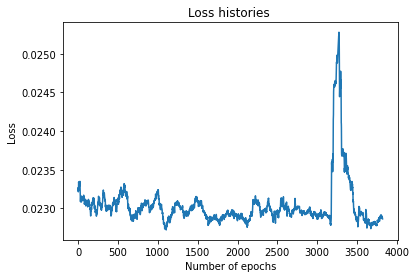

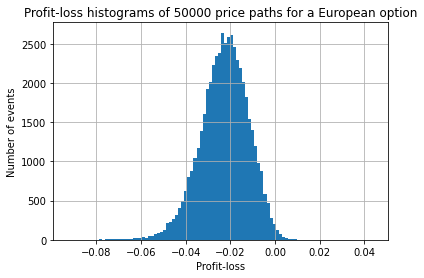

Option price is  [0.02278525]


In [6]:
pnl = hedger.compute_pnl(data_set)
price = to_numpy(hedger.pricer())
plot_history(history)
plot_pnl(pnl)
print('Option price is ', price)


### Deep Hedger

In [7]:
models = [MultiLayerPerceptron(out_features = n_asset) for t in range(time_steps)]
hedger = datahedger.DeepHedger(models, dataset_market) 
history = hedger.fit(50)  

/Users/hous/Library/Caches/pypoetry/virtualenvs/pfhedge-VzMHHErp-py3.8/lib/python3.8/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
Loss=0.02230975031852722: 100%|██████████| 50/50 [01:33<00:00,  1.88s/it] 


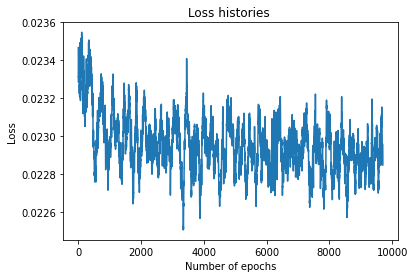

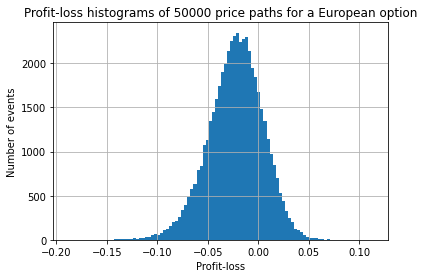

Option price is  [0.02277917]


In [8]:
pnl = hedger.compute_pnl(data_set)
price = to_numpy(hedger.pricer())
plot_history(history)
plot_pnl(pnl)
print('Option price is ', price)


### Heston Model

In [9]:
from pfhedge.instruments import EuropeanOption
from pfhedge.instruments import HestonStock
from pfhedge.instruments import VarianceSwap
from pfhedge.nn import MultiLayerPerceptron

kappa = 1.
theta = 0.04
sigma = 0.2
rho = -0.7
v0 = 0.04
s0 = 100.
init_state = (s0,v0)

dt = 1/365
maturity = 30/365

N_PATHS = 50000

derivative = EuropeanOption(HestonStock(kappa = kappa, theta = theta, sigma = sigma, rho = rho, dt = dt), strike = s0, maturity=maturity)
stock = derivative.underlier
derivative.simulate(N_PATHS, init_state=init_state)

time_steps = ceil(maturity / dt)
time_to_maturity = torch.linspace(maturity, 0, time_steps + 1)
time_to_maturity = torch.tile(time_to_maturity, [N_PATHS,1])[...,None]

payoff = derivative.payoff_fn()[:,None]
prices_heston = stock.spot[...,None]
variance_heston = stock.variance[...,None]

L_func = lambda tau,v: (v-theta) / kappa * (1-(-kappa*(tau)).exp()) + theta*tau
prices_varswap = torch.cumsum(variance_heston,dim=1) * stock.dt + L_func(time_to_maturity, variance_heston)

prices = torch.Tensor(torch.cat([prices_heston, prices_varswap],axis = -1))
n_asset = prices.shape[-1]

information = torch.cat([
    torch.log(prices_heston),
    variance_heston,
    time_to_maturity
    ], axis = -1)

data_set = [prices, information, payoff]

dataset_market = datahedger.MarketDataset(data_set)


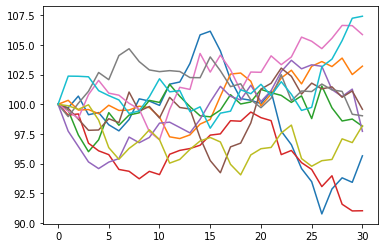

In [10]:
plt.plot(prices_heston[:10,:,-1].T)
plt.show()

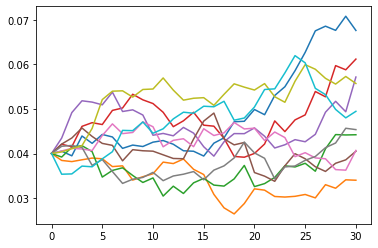

In [11]:
plt.plot(variance_heston[:10,:,-1].T)
plt.show()

In [12]:
d = n_asset
models = [MultiLayerPerceptron(n_layers = 2, n_units = (d+15,d+15), out_features = d) for t in range(time_steps)]
hedger = datahedger.DeepHedger(models, dataset_market) 


/Users/hous/Library/Caches/pypoetry/virtualenvs/pfhedge-VzMHHErp-py3.8/lib/python3.8/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [13]:
history = hedger.fit(50)  

Loss=3.1299993991851807: 100%|██████████| 50/50 [01:06<00:00,  1.33s/it]


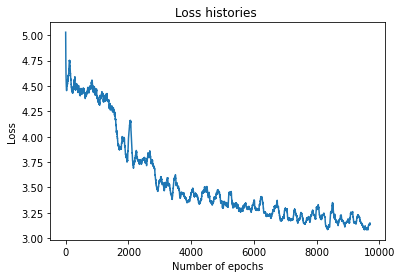

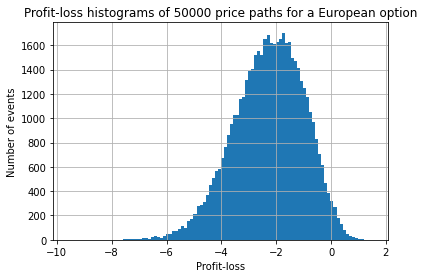

Option price is  [3.220983]


In [14]:
pnl = hedger.compute_pnl(data_set)
price = to_numpy(hedger.pricer())
plot_history(history)
plot_pnl(pnl)
print('Option price is ', price)    

### Deep Calibration 